서울시 구별 CCTV 현황 분석
- 서울시 각 구별 CCTV 수를 확인하고, 
- 인구대비 CCTV 비율 파악하고 순위 비교
- 인구대비 CCTV 평균 확인하고 CCTV 부족한 구 확인

분석에 사용하는 데이터
- 서울시 자치구 연도별 CCTV 설치 현황 : '01. CCTV_in_Seoul.csv'
- 서울시 인구 현황 : '01. population_in_Seoul.xls'

데이터 분석 작업 순서

1. 파일로부터 데이터 읽어 오기
    - (1) CCTV 파일 읽어 오기
        - '구별' 열 이름 변경
    - (2) 서울시 인구현황 파일 읽어 오기
        - 열 이름 변경
        
2. 데이터 파악
    - (1) CCTV 데이터 파악
        - CCTV가 가장 많은 구 / 적은 구 파악
        - 최근 CCTV 증가율 구하기
    - (2) 서울시 인구 데이터 파악
        - 필요 없는 행 삭제
        - 구 이름 확인
        - NaN 확인하고 포함된 행 삭제
        - 인구 분석 작업 
            - 외국인 비율 / 고령자 비율 구하기
            - 인구가 제일 많은 구
            - 외국인이 가장 많은 구
            - 외국인 비율이 제일 높은 구
            - 고령자가 가장 많은 구
            
3. CCTV 데이터와 인구 데이터 합치고 분석하기
    - 구별 기준으로 데이터 합치기
    - 의미 없는 열 삭제
    - 구별로 인덱스 설정
    - 상관관계 분석

4. CCTV와 인구현황 그래프 작성하고 분석하기
    - CCTV 현황 그래프 : 수평 막대 그래프
    - 인구대비 CCTV 비율을 계산해서 정렬하고 막대 그래프로 출력
    - 분산형(산점도) 그래프 출력
    - 인구수대비 몇 대의 CCTV 수가 적당한지 알기 위해서
        - 인구수와 CCTV 수를 이용해서 최소오차 직선식 그리기
    - 결과 분석

5. 결과를 파일로 저장 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. 파일로부터 데이터 읽어 오기

### (1) CCTV 파일 읽어 오기

In [5]:
CCTV_seoul = pd.read_csv('../data/01. CCTV_in_Seoul.csv', encoding='utf-8')
CCTV_seoul.head()

,기관명,소계,2013년도 이전,2014년,2015년,2016년
0,강남구,3238,1292,430,584,932
1,강동구,1010,379,99,155,377
2,강북구,831,369,120,138,204
3,강서구,911,388,258,184,81
4,관악구,2109,846,260,390,613


In [ ]:
# 상대경로 : '../data/01. CCTV_in_Seoul.csv', encoding='utf-8'
# 현재 디럭테러 (./)에서 루트로 나갔다가 data 폴더로 들어감
# 같은 폴더에 있으면 파일명만 적거나 './' 적으면 됨

In [4]:
CCTV_seoul.tail()

,기관명,소계,2013년도 이전,2014년,2015년,2016년
20,용산구,2096,1368,218,112,398
21,은평구,2108,1138,224,278,468
22,종로구,1619,464,314,211,630
23,중구,1023,413,190,72,348
24,중랑구,916,509,121,177,109


In [7]:
# 열 이름(컬럼명) 출력
CCTV_seoul.columns

Index(['기관명', '소계', '2013년도 이전', '2014년', '2015년', '2016년'], dtype='object')

In [8]:
# 열 이름 중에서 첫 번째 항목 출력
CCTV_seoul.columns[0]

'기관명'

In [10]:
# '기관명'을 '구별'로 변경
CCTV_seoul.rename(columns={CCTV_seoul.columns[0] : '구별'},inplace=True)
CCTV_seoul.head()
# inplace=True : 변수의 내용 갱신 (작업 완료) --- 없으면 변경되지 않음

,구별,소계,2013년도 이전,2014년,2015년,2016년
0,강남구,3238,1292,430,584,932
1,강동구,1010,379,99,155,377
2,강북구,831,369,120,138,204
3,강서구,911,388,258,184,81
4,관악구,2109,846,260,390,613


### (2) 서울시 인구현황 파일 읽어 오기

In [12]:
# 엑셀 파일 읽기
pop_seoul = pd.read_excel('../data/01. population_in_Seoul.xls',encoding='utf-8')
pop_seoul.head()

,기간,자치구,세대,인구,인구.1,인구.2,인구.3,인구.4,인구.5,인구.6,인구.7,인구.8,세대당인구,65세이상고령자
0,기간,자치구,세대,합계,합계,합계,한국인,한국인,한국인,등록외국인,등록외국인,등록외국인,세대당인구,65세이상고령자
1,기간,자치구,세대,계,남자,여자,계,남자,여자,계,남자,여자,세대당인구,65세이상고령자
2,2017.1/4,합계,4202888,10197604,5000005,5197599,9926968,4871560,5055408,270636,128445,142191,2.36,1321458
3,2017.1/4,종로구,72654,162820,79675,83145,153589,75611,77978,9231,4064,5167,2.11,25425
4,2017.1/4,중구,59481,133240,65790,67450,124312,61656,62656,8928,4134,4794,2.09,20764


In [13]:
pop_seoul.columns

Index(['기간', '자치구', '세대', '인구', '인구.1', '인구.2', '인구.3', '인구.4', '인구.5', '인구.6',
       '인구.7', '인구.8', '세대당인구', '65세이상고령자'],
      dtype='object')

In [19]:
# 필요 없는 행과 열 제외하고 필요한 부분만 읽어 오기
# 행은 세 번째 줄부터 읽고
# 열은 B, D, G, J, N만 읽어 오는 옵션 추가해서 파일 읽기

pop_seoul = pd.read_excel('../data/01. population_in_Seoul.xls',
                          encoding='utf-8',
                          header = 2, # 0,1,2 (세 번째 행)
                          usecols = 'B,D,G,J,N') # 선택 열

pop_seoul.head()

,자치구,계,계.1,계.2,65세이상고령자
0,합계,10197604.0,9926968.0,270636.0,1321458.0
1,종로구,162820.0,153589.0,9231.0,25425.0
2,중구,133240.0,124312.0,8928.0,20764.0
3,용산구,244203.0,229456.0,14747.0,36231.0
4,성동구,311244.0,303380.0,7864.0,39997.0


In [24]:
# 열 이름 변경 : 구별, 인구수, 한국인, 외국인, 고령자
# pop_seoul.columns=['A','B','C','D','E']
# pop_seoul.head()

pop_seoul.rename(columns={
    pop_seoul.columns[0] : '구별',
    pop_seoul.columns[1] : '인구수',
    pop_seoul.columns[2] : '한국인',
    pop_seoul.columns[3] : '외국인',
    pop_seoul.columns[4] : '고령자'}, inplace=True)

pop_seoul.head()

,구별,인구수,한국인,외국인,고령자
0,합계,10197604.0,9926968.0,270636.0,1321458.0
1,종로구,162820.0,153589.0,9231.0,25425.0
2,중구,133240.0,124312.0,8928.0,20764.0
3,용산구,244203.0,229456.0,14747.0,36231.0
4,성동구,311244.0,303380.0,7864.0,39997.0


## 2. 데이터 파악

### (1) CCTV 데이터 파악

In [26]:
CCTV_seoul.head()

,구별,소계,2013년도 이전,2014년,2015년,2016년
0,강남구,3238,1292,430,584,932
1,강동구,1010,379,99,155,377
2,강북구,831,369,120,138,204
3,강서구,911,388,258,184,81
4,관악구,2109,846,260,390,613


In [27]:
# '소계'를 기준으로 오름차순 정렬
CCTV_seoul.sort_values(by='소계').head()
# 의미 : CCTV가 가장 작은 구 5개

,구별,소계,2013년도 이전,2014년,2015년,2016년
9,도봉구,825,238,159,42,386
2,강북구,831,369,120,138,204
5,광진구,878,573,78,53,174
3,강서구,911,388,258,184,81
24,중랑구,916,509,121,177,109


In [28]:
CCTV_seoul.sort_values(by='소계',ascending=False).head()
# 의미 : CCTV가 가장 많은 구 5개

,구별,소계,2013년도 이전,2014년,2015년,2016년
0,강남구,3238,1292,430,584,932
18,양천구,2482,1843,142,30,467
14,서초구,2297,1406,157,336,398
4,관악구,2109,846,260,390,613
21,은평구,2108,1138,224,278,468


In [34]:
# 최근 3년간 CCTV 증가율
# - 최근 3년에 해당되는 2014~2016년의 CCTV 수를 더해서
# - 2013년 이전 CCTV 수로 나눈 다음
# 곱하기 100

# '최근증가율' 열 추가
CCTV_seoul['최근증가율']= (CCTV_seoul['2016년']+\
                      CCTV_seoul['2015년']+\
                      CCTV_seoul['2014년']) / CCTV_seoul['2013년도 이전'] * 100
CCTV_seoul
# 행이 길어서 여러 행으로 나눌 경우 역슬래시(\) 사용

# '최근증가율'이 높은 구 5개 확인
CCTV_seoul.sort_values(by='최근증가율',ascending=False).head()

,구별,소계,2013년도 이전,2014년,2015년,2016년,최근증가율
22,종로구,1619,464,314,211,630,248.922414
9,도봉구,825,238,159,42,386,246.638655
12,마포구,980,314,118,169,379,212.101911
8,노원구,1566,542,57,451,516,188.929889
1,강동구,1010,379,99,155,377,166.490765


### (2) 서울시 인구 데이터 파악

In [ ]:
# 서울시 인구 현황 확인
pop_seoul.head()

In [39]:
# 불필요한 0행 삭제 : drop() 함수 사용
pop_seoul.drop([0], inplace=True)
pop_seoul.head()

,구별,인구수,한국인,외국인,고령자
1,종로구,162820.0,153589.0,9231.0,25425.0
2,중구,133240.0,124312.0,8928.0,20764.0
3,용산구,244203.0,229456.0,14747.0,36231.0
4,성동구,311244.0,303380.0,7864.0,39997.0
5,광진구,372164.0,357211.0,14953.0,42214.0


In [40]:
# 구 이름 확인
# - 구 이름 외에 다른 것이 들어 있는지 검사
# '구별'의 이름을 한 번씩만 출력해서 확인

# unique() 함수 : 반복된 값은 한 번만 출력

pop_seoul['구별'].unique()

array(['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구',
       '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구',
       '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구', nan],
      dtype=object)

In [47]:
# NaN이 들어있는지 확인 : isnull() 함수 사용
# '구별'의 각 행마다 NaN이 들어있는지 확인
pop_seoul[pop_seoul['구별'].isnull()]

,구별,인구수,한국인,외국인,고령자
26,NaN,NaN,NaN,NaN,NaN


In [ ]:
# pop_seoul

In [53]:
# NaN이 들어있는 행 삭제
pop_seoul.drop([26], inplace=True)
pop_seoul

In [66]:
# '외국인비율'과 '고령자비율' 계산해서 열 추가

# '외국인비율' = 외국인 / 전체 인구수 * 100
pop_seoul['외국인비율']= pop_seoul['외국인']/pop_seoul['인구수']*100

# '고령자비율' = 고령자 / 전체 인구수 * 100
pop_seoul['고령자비율']= pop_seoul['고령자']/pop_seoul['인구수']*100

pop_seoul.head()

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
1,종로구,162820.0,153589.0,9231.0,25425.0,5.669451,15.615404
2,중구,133240.0,124312.0,8928.0,20764.0,6.700690,15.583909
3,용산구,244203.0,229456.0,14747.0,36231.0,6.038828,14.836427
4,성동구,311244.0,303380.0,7864.0,39997.0,2.526635,12.850689
5,광진구,372164.0,357211.0,14953.0,42214.0,4.017852,11.342849


In [70]:
# 인구가 가장 많은 구 확인(5개)
# '인구수'를 기준으로 내림차순 정렬
pop_seoul.sort_values(by='인구수',ascending=False).head()

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
24,송파구,667483.0,660584.0,6899.0,72506.0,1.033584,10.862599
16,강서구,603772.0,597248.0,6524.0,72548.0,1.080540,12.015794
23,강남구,570500.0,565550.0,4950.0,63167.0,0.867660,11.072217
11,노원구,569384.0,565565.0,3819.0,71941.0,0.670725,12.634883
21,관악구,525515.0,507203.0,18312.0,68082.0,3.484582,12.955291


In [71]:
# 외국인이 가장 많은 구 확인(5개)
# '외국인'을 기준으로 내림차순 정렬
pop_seoul.sort_values(by='외국인',ascending=False).head()

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
19,영등포구,402985.0,368072.0,34913.0,52413.0,8.663598,13.006191
17,구로구,447874.0,416487.0,31387.0,56833.0,7.007998,12.689506
18,금천구,255082.0,236353.0,18729.0,32970.0,7.342345,12.925255
21,관악구,525515.0,507203.0,18312.0,68082.0,3.484582,12.955291
6,동대문구,369496.0,354079.0,15417.0,54173.0,4.172440,14.661322


In [76]:
# 외국인 비율이 가장 높은 구 확인(5개)
# ' 외국인비율'을 기준으로 내림차순 정렬
pop_seoul.sort_values(by='외국인비율',ascending=False).head()

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
19,영등포구,402985.0,368072.0,34913.0,52413.0,8.663598,13.006191
18,금천구,255082.0,236353.0,18729.0,32970.0,7.342345,12.925255
17,구로구,447874.0,416487.0,31387.0,56833.0,7.007998,12.689506
2,중구,133240.0,124312.0,8928.0,20764.0,6.700690,15.583909
3,용산구,244203.0,229456.0,14747.0,36231.0,6.038828,14.836427


In [73]:
# 고령자가 가장 많은 구 확인(5개)
# ' 고령자'를 기준으로 내림차순 정렬
pop_seoul.sort_values(by='고령자',ascending=False).head()

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
16,강서구,603772.0,597248.0,6524.0,72548.0,1.080540,12.015794
24,송파구,667483.0,660584.0,6899.0,72506.0,1.033584,10.862599
12,은평구,494388.0,489943.0,4445.0,72334.0,0.899091,14.631019
11,노원구,569384.0,565565.0,3819.0,71941.0,0.670725,12.634883
21,관악구,525515.0,507203.0,18312.0,68082.0,3.484582,12.955291


In [74]:
# 고령자 비율이 높은 구 확인(5개)
# ' 고령자비율'을 기준으로 내림차순 정렬
pop_seoul.sort_values(by='고령자비율',ascending=False).head()

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
9,강북구,330192.0,326686.0,3506.0,54813.0,1.061806,16.600342
1,종로구,162820.0,153589.0,9231.0,25425.0,5.669451,15.615404
2,중구,133240.0,124312.0,8928.0,20764.0,6.700690,15.583909
3,용산구,244203.0,229456.0,14747.0,36231.0,6.038828,14.836427
13,서대문구,327163.0,314982.0,12181.0,48161.0,3.723221,14.720797


## 3. CCTV 데이터와 인구 데이터 합치고 분석하기

In [78]:
# CCTV 데이터 확인
CCTV_seoul.head()

,구별,소계,2013년도 이전,2014년,2015년,2016년,최근증가율
0,강남구,3238,1292,430,584,932,150.619195
1,강동구,1010,379,99,155,377,166.490765
2,강북구,831,369,120,138,204,125.203252
3,강서구,911,388,258,184,81,134.793814
4,관악구,2109,846,260,390,613,149.290780


In [80]:
# 서울시 인구 현황 데이터 확인
pop_seoul.head()

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
1,종로구,162820.0,153589.0,9231.0,25425.0,5.669451,15.615404
2,중구,133240.0,124312.0,8928.0,20764.0,6.700690,15.583909
3,용산구,244203.0,229456.0,14747.0,36231.0,6.038828,14.836427
4,성동구,311244.0,303380.0,7864.0,39997.0,2.526635,12.850689
5,광진구,372164.0,357211.0,14953.0,42214.0,4.017852,11.342849


In [85]:
# CCTV 데이터와 인구 현황 데이터 병합
data_result = pd.merge(CCTV_seoul,pop_seoul, on='구별')
data_result.head()

,구별,소계,2013년도 이전,2014년,2015년,2016년,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
0,강남구,3238,1292,430,584,932,150.619195,570500.0,565550.0,4950.0,63167.0,0.867660,11.072217
1,강동구,1010,379,99,155,377,166.490765,453233.0,449019.0,4214.0,54622.0,0.929765,12.051638
2,강북구,831,369,120,138,204,125.203252,330192.0,326686.0,3506.0,54813.0,1.061806,16.600342
3,강서구,911,388,258,184,81,134.793814,603772.0,597248.0,6524.0,72548.0,1.080540,12.015794
4,관악구,2109,846,260,390,613,149.290780,525515.0,507203.0,18312.0,68082.0,3.484582,12.955291


In [86]:
# data_result 열 이름 출력
data_result.columns 

Index(['구별', '소계', '2013년도 이전', '2014년', '2015년', '2016년', '최근증가율', '인구수',
       '한국인', '외국인', '고령자', '외국인비율', '고령자비율'],
      dtype='object')

In [87]:
# 의미 없는 열 삭제 : del 명령
# 행 삭제 : drop() 함수
del data_result['2013년도 이전']
del data_result['2014년']
del data_result['2015년']
del data_result['2016년']

data_result.head()

,구별,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
0,강남구,3238,150.619195,570500.0,565550.0,4950.0,63167.0,0.867660,11.072217
1,강동구,1010,166.490765,453233.0,449019.0,4214.0,54622.0,0.929765,12.051638
2,강북구,831,125.203252,330192.0,326686.0,3506.0,54813.0,1.061806,16.600342
3,강서구,911,134.793814,603772.0,597248.0,6524.0,72548.0,1.080540,12.015794
4,관악구,2109,149.290780,525515.0,507203.0,18312.0,68082.0,3.484582,12.955291


In [94]:
# 그래프 작성 시 인덱스로 구 이름이 출력되도록
# index를 '구별'로 설정
# data_result.set_index('구별') # 출력만
data_result.set_index('구별', inplace=True)

In [95]:
data_result.head()

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
구별,,,,,,,,
강남구,3238,150.619195,570500.0,565550.0,4950.0,63167.0,0.867660,11.072217
강동구,1010,166.490765,453233.0,449019.0,4214.0,54622.0,0.929765,12.051638
강북구,831,125.203252,330192.0,326686.0,3506.0,54813.0,1.061806,16.600342
강서구,911,134.793814,603772.0,597248.0,6524.0,72548.0,1.080540,12.015794
관악구,2109,149.290780,525515.0,507203.0,18312.0,68082.0,3.484582,12.955291


상관관계 분석

지금까지 인구 데이터를 분석해서 '고령자비율', '외국인비율'을 구하고,
'고령자비율', '외국인비율', '인구수' 등을 기준으로 정렬해서
각 항목별 순위를 살펴보았음

이제, '고령자비율', '외국인비율', '인구수' 중에서 어떤 데이터와 CCTV를 비교할지 결정해야 함

가장 단순한 작업이 상관관계를 조사하는 것으로
상관계수를 계산하여 구하고
상관계수가 가장 큰 값의 데이터와 비교

상관관계 (corelation coeficient)
- 한 변수의 변화에 따른 다른 변수의 변화 정도와 방향을 예측하는 분석기법
- 두 데이터 간의 관계를 파악하는데 사용

상관관계를 분석하기 위해서는
- 상관계수의 절대값 수치를 확인하여
- 상관관계가 있는지 확인

상관계수 : 두 데이터가 어느 정도의 관계를 가지고 있는지를 보여주는 계수

상관관계의 절대값이
- 0.1 이하면 거의 무시
- 0.3 이하면 약한 상관관계
- 0.7 뚜렷한 상관관계가 존재한다

상관계수 계산
- numpy 라이브러리의 corrcoef() 함수 사용
- 결과를 행렬로 반환
- 주 대각선을 기준으로 대칭인 행렬로
- 대각선을 제외한 다른 값이 상관계수가 됨

In [96]:
# 상관계수 계산에 사용할 데이터
data_result.head()

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
구별,,,,,,,,
강남구,3238,150.619195,570500.0,565550.0,4950.0,63167.0,0.867660,11.072217
강동구,1010,166.490765,453233.0,449019.0,4214.0,54622.0,0.929765,12.051638
강북구,831,125.203252,330192.0,326686.0,3506.0,54813.0,1.061806,16.600342
강서구,911,134.793814,603772.0,597248.0,6524.0,72548.0,1.080540,12.015794
관악구,2109,149.290780,525515.0,507203.0,18312.0,68082.0,3.484582,12.955291


In [99]:
# '고령자비율'과 CCTV '소계' 상관계수 구하기
np.corrcoef(data_result['고령자비율'],data_result['소계'])

# 절대값이 0.258
# 고령자비율 : 소계 = 0.258 --> 약한 상관관계가 있다(상관계수 0.3 이하)

array([[ 1.        , -0.25866272],
       [-0.25866272,  1.        ]])

In [100]:
# ' 외국인비율'과 '소계' 상관계수 구하기
np.corrcoef(data_result['외국인비율'],data_result['소계'])

# 절대값이 0.052 
# 외국인비율 : 소계 = 0.052 --> 무시(상관계수 0.1 이하)

array([[ 1.        , -0.05230165],
       [-0.05230165,  1.        ]])

In [101]:
# '인구수'와 '소계' 상관계수 구하기
np.corrcoef(data_result['인구수'],data_result['소계'])

# 절대값이 0.243
# 인구수 : 소계 = 0.243 --> 약한 상관관계가 있다(상관계수 0.3 이하)

array([[1.       , 0.2432198],
       [0.2432198, 1.       ]])

In [ ]:
CCTV 개수와의 상관계수 결과
고령자비율 : 소계 = 0.258 --> 약한 상관관계
외국인비율 : 소계 = 0.052 --> 무시
인구수 : 소계 = 0.243 --> 약한 상관관계
    
상관계수 비교 결과
- 'CCTV 개수'와 '외국인' 간에는 거의 상관관계가 없고
- 'CCTV 개수'와 '고령자' 및 '인구수' 간에는 약한 상관관계가 있다 

In [ ]:
# 위의 상관계수 분석결과에 따라 다음 수행 작업 선정
'CCTV 개수'와 '고령자' 비율은 약한 음의 상관관계이고, (음수)
외국인 비율과는 큰 의미가 없다고 할 수 있음

그런데, '인구수'와는 상관관계가 0.243 약한 상관관계가 있으므로
CCTV와 인구수와의 관계를 좀 더 분석할 예정임

In [102]:
# CCTV가 많이 설치된 구를 확인하기 위해
# '소계'를 기준으로 내림차순 정렬
data_result.sort_values(by='소계',ascending=False).head()

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
구별,,,,,,,,
강남구,3238,150.619195,570500.0,565550.0,4950.0,63167.0,0.867660,11.072217
양천구,2482,34.671731,479978.0,475949.0,4029.0,52975.0,0.839413,11.036964
서초구,2297,63.371266,450310.0,445994.0,4316.0,51733.0,0.958451,11.488308
관악구,2109,149.290780,525515.0,507203.0,18312.0,68082.0,3.484582,12.955291
은평구,2108,85.237258,494388.0,489943.0,4445.0,72334.0,0.899091,14.631019


In [103]:
# '인구수'를 기준으로 내림차순 정렬
data_result.sort_values(by='인구수',ascending=False).head()

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
구별,,,,,,,,
송파구,1081,104.347826,667483.0,660584.0,6899.0,72506.0,1.033584,10.862599
강서구,911,134.793814,603772.0,597248.0,6524.0,72548.0,1.080540,12.015794
강남구,3238,150.619195,570500.0,565550.0,4950.0,63167.0,0.867660,11.072217
노원구,1566,188.929889,569384.0,565565.0,3819.0,71941.0,0.670725,12.634883
관악구,2109,149.290780,525515.0,507203.0,18312.0,68082.0,3.484582,12.955291


다음 수행 작업
- CCTV가 많이 설치된 구와 인구수가 많은 구를 시각적으로 비교
- 시각화 도구를 사용해서 그래프 분석 작업 수행

## 4. CCTV와 인구현황 그래프로 분석하기

In [104]:
# 한글 문제
# matplotlib의 기본 폰트에서 한글이 지원되지 않기 때문에
# matplotlib의 폰트 변경 필요
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

In [105]:
# 그래프 분석에 사용할 데이터
data_result.head()

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
구별,,,,,,,,
강남구,3238,150.619195,570500.0,565550.0,4950.0,63167.0,0.867660,11.072217
강동구,1010,166.490765,453233.0,449019.0,4214.0,54622.0,0.929765,12.051638
강북구,831,125.203252,330192.0,326686.0,3506.0,54813.0,1.061806,16.600342
강서구,911,134.793814,603772.0,597248.0,6524.0,72548.0,1.080540,12.015794
관악구,2109,149.290780,525515.0,507203.0,18312.0,68082.0,3.484582,12.955291


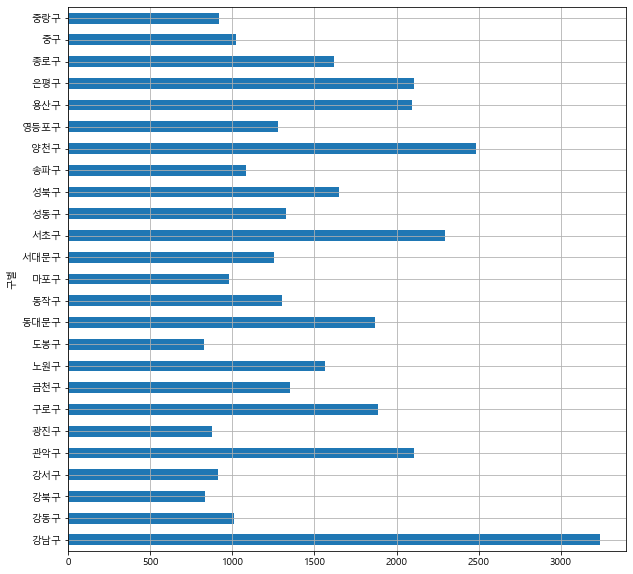

In [131]:
# CCTV 현황 '소계'를 수평 막대 그래프로 출력
data_result['소계'].plot(kind='barh', grid=True, figsize=(10,10))
plt.show()

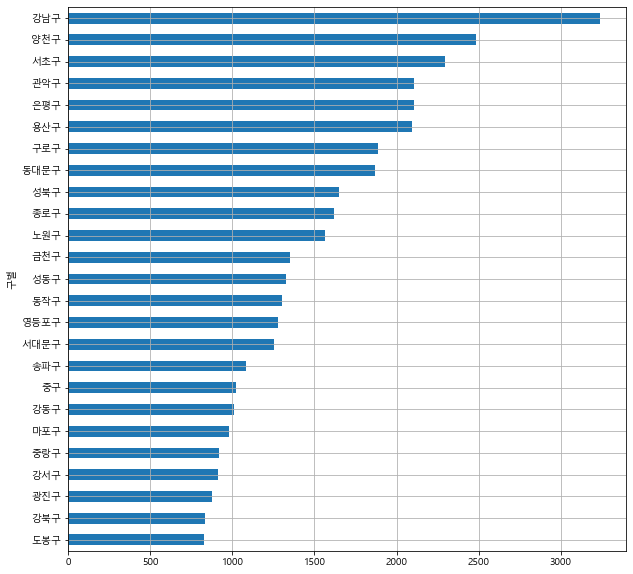

In [133]:
# 수평 바 그래프 
# '소계' 기준으로 내림차순 정렬
data_result['소계'].sort_values().plot(kind='barh', grid=True, figsize=(10,10))

plt.show()
# 결과 : 강남구가 월등히 많고, 이어서 양천구, 서초구, 관악구, 은평구 순

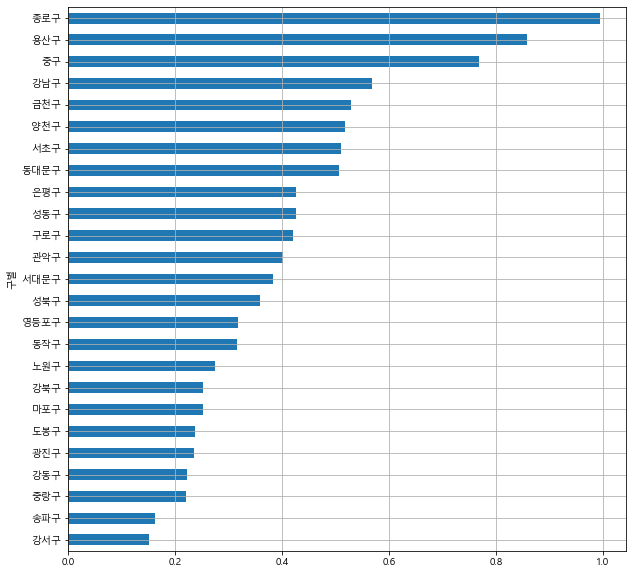

In [134]:
# 인구 대비 CCTV 비율을 계산해서 정렬하고 그래프로 출력
# 수평 바 그래프
# CCTV비율 = 소계 / 인구수 * 100

data_result['CCTV비율'] = data_result['소계'] / data_result['인구수'] * 100
data_result['CCTV비율'].sort_values().plot(kind='barh', grid=True, figsize=(10,10))
plt.show()

# 높은 구 : 종로구와 용산구, 중구가 월등히 높음
# 낮은 구 : 강서구, 송파구가 낮음

# 강남구, 양천구, 서초구, 관악구, 은평구는 CCTV 설치 개수는 많지만,
# 인구대비 CCTV 비율에서는
# 강남구, 양천구, 서초구는 상위에 포함되고,
# 은평구, 관악구는 중간 정도에 위치함

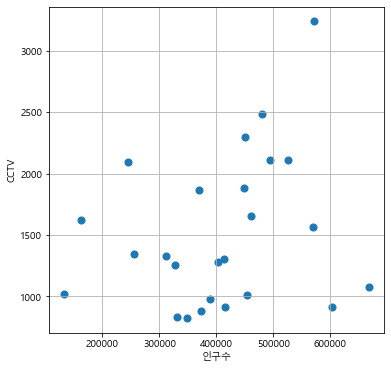

In [135]:
# 분산형(산포도) 그래프 출력
# 인구수 VS. CCTV

plt.figure(figsize=(6,6))
plt.scatter(data_result['인구수'], data_result['소계'], s=50)

plt.xlabel('인구수')
plt.ylabel('CCTV')

plt.grid()
plt.show()

인구수와 CCTV를 이용해서 최소오차 직선식을 구해서 그래프 그리기 작업 순서
1. 최소오차 직선식 구하기
- 직선식의 계수 구하기 (y=ax+b) : numpy의 ployfit() 함수 사용
    - a : 기울기
    - b : 절편

2. 최소오차 직선식의 그래프 그리기
- 그래프를 그리려면 x, y값이 필요한데,
- 1.에서 구한 직선식의 계수만으로는 그래프를 그릴 수 없음
- 그래프를 그리기 위한 x, y 값 생성 필요
    - x : 균일한 간격의 점을 자동 생성 (linspace() 함수 사용)
    - y : 위에서 구한 직선식에 해당되는 y값 필요
        - x값을 받아서 직선식에 맞는 y값으로 변환하기 위한 함수 필요
        - 위에서 구한 기울기와 절편을 이용해서 y값으로 변환하기 위한 함수를 생성 (poly1d() 함수 사용)
        - 이 함수의 역할 : x값을 받아서 우리가 구한 최소오차 직선식에 맞는 y값을 반환

- 이렇게 귀한 x, y값으로 그래프에 최소오차 직선을 그릴 수 있음

In [136]:
# 최소오차 직선식의 계수 구하기

# 인구수와 CCTV 수가 양의 상관관계가 있으므로
# 인구수 대비 몇 대의 CCTV 수가 적당한지 알기 위해
# 인구수와 CCTV 수를 이용해서 최소오차 직선식의 계수 구하기

# 최소오차 직선식 : ax + b
# a : 기울기
# b : 절편

# polyfit() 함수를 사용해서 최소오차 직선식 구함
# polyfit(x. y. 차수) : 오차가 가장 적은 n차 방정식의 계수 반환
# 1차식인 경우 : 직선식 ax + b --- a와 b 반환 (기울기와 절편 반환)

# '인구수'와 CCTV '소계' 데이터에서 최소오차 직선식의 계수 구하기
polyfit_result = np.polyfit(data_result['인구수'],
                           data_result['소계'],
                           1)
polyfit_result # 기울기와 절편 (최소오차 직선식의 계수)
# a(기울기) : 1.15151285e-03
# b(절편) : 1.04561312e+03

array([1.15151285e-03, 1.04561312e+03])

In [ ]:
# np.polyfit(x, y, 차수) 
# - 입력과 출력 값으로 다항식의 계수를 찾아주는 함수

In [144]:
# 그래프를 그리기 위한 x값을 받아서
# 직선식에 맞는 y값으로 변환하기 위한 함수 만들기

# 계수로는 그래프를 그리기 위한 y축 예측값을 찾을 수 없고,
# 함수로 만들어서 입력을 주고 결과를 얻어야 하기 때문에
# poly1d() 함수를 사용해서 함수 생성 : 결과를 함수로 받음

# 계수 polyfit_result를 대입한 방정식
# - 1.15151285e-03x + 1.04561312e+03
# 함수 = poly1d(polyfit_result)
# - polyfit_result를 poly1d() 함수에게 전달하고 그 결과로 함수를 받음
func = np.poly1d(polyfit_result)
# 이렇게 만들어진 함수 func()의 용도
# - 직선식을 그리는데 필요한 y값을 구하는데 사용

In [138]:
# 최소오차 직선식을 그리는데 필요한 x값 생성
# - numpy의 linspace() 함수 사용
# x축의 범위 : x축 점의 개수 지정

# linspace(start, end, num(개))
# - start~end 범위에서 균일한 간격으로 수치(점)를 num(개) 생성
x_nums = np.linspace(100000, 700000, 100)
# x_nums

In [ ]:
# np.linspace(start, end, num(개))
# - 시작점과 끝점을 균일 간격으로 나눈 점들 생성
# - start~end 사이의 값을 num개 만큼 생성하여 배열로 반환
# - 그래프 그리기에서 수평축(x축)의 간격을 만드는데 매우 유용하게 사용할 수 있는 함수

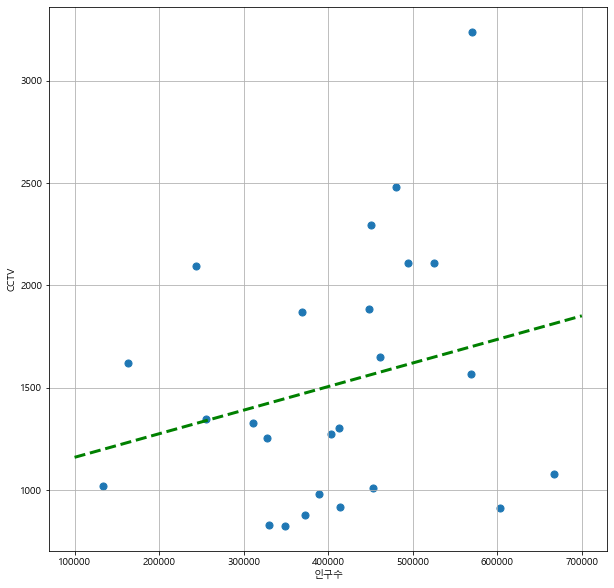

In [145]:
# 그래프 그리기
# 인구대비 CCTV 소계의 분산형(산점도) 그래프 위해
# 최소오차 직선식 표시

# 분산형(산점도)
plt.figure(figsize=(10,10))
plt.scatter(data_result['인구수'],data_result['소계'], s=50)

# 최소오차 직선 표시 : plot() 함수 사용
# x 값 : linspace()로 구한 x_nums 사용
# y 값 : x값을 받아서 최소오차 직선식에 맞는 y값을 반환하는 func() 함수 사용 
plt.plot(x_nums,func(x_nums), ls='dashed',lw=3, color='g')

plt.xlabel('인구수')
plt.ylabel('CCTV')

plt.grid()
plt.show()

In [146]:
# 직선의 의미
# 인구수를 직선에 대입해서 얻은 수치
# - 인구수 대비 적정 CCTV 개수
# x 대신 인구수 400,000명 대입
y = 1.15151285e-03 * 400000 + 1.04561312e+03
y # 1506.21826

# 인구수가 400,4000명일 때 CCTV는 1506개 정도 되어야 한다는 의미
# 직선의 위쪽은 적정 수치보다 많이 설치된 지역이고,
# 직선의 아래쪽은 적정 수치보다 적게 설치된 지역

1506.21826

In [149]:
### 조금 더 설득력 있는 데이터 만들기
# 오차를 계산하고 오차가 큰 순으로 데이터 정렬
polyfit_result = np.polyfit(data_result['인구수'],
                           data_result['소계'],
                           1)
func = np.poly1d(polyfit_result)
x_nums = np.linspace(100000, 700000, 100)

# abs() 함수를 사용해서 오차를 양수로 표현
data_result['오차'] = np.abs(data_result['소계']-func(data_result['인구수']))

df_sort = data_result.sort_values(by='오차', ascending=False)
df_sort

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율,CCTV비율,오차
구별,,,,,,,,,,
강남구,3238,150.619195,570500.0,565550.0,4950.0,63167.0,0.867660,11.072217,0.567572,1535.448801
양천구,2482,34.671731,479978.0,475949.0,4029.0,52975.0,0.839413,11.036964,0.517107,883.686047
강서구,911,134.793814,603772.0,597248.0,6524.0,72548.0,1.080540,12.015794,0.150885,829.864334
용산구,2096,53.216374,244203.0,229456.0,14747.0,36231.0,6.038828,14.836427,0.858302,769.183989
송파구,1081,104.347826,667483.0,660584.0,6899.0,72506.0,1.033584,10.862599,0.161952,733.228369
서초구,2297,63.371266,450310.0,445994.0,4316.0,51733.0,0.958451,11.488308,0.510093,732.849130
도봉구,825,246.638655,348646.0,346629.0,2017.0,51312.0,0.578524,14.717507,0.236630,622.083467
중랑구,916,79.960707,414503.0,409882.0,4621.0,56774.0,1.114829,13.696885,0.220988,606.918649
광진구,878,53.228621,372164.0,357211.0,14953.0,42214.0,4.017852,11.342849,0.235917,596.164747


In [ ]:
결과 분석
- 인구수가 400,000일 때
- CCTV 개수는 1,506개 정도가 되어야 한다고 했는데

동작구의 경우
- 인구수 : 412,520
- CCTV 수 : 1,302개
- 오차 : 218.6
- 인구수에 비해 CCTV 개수 부족

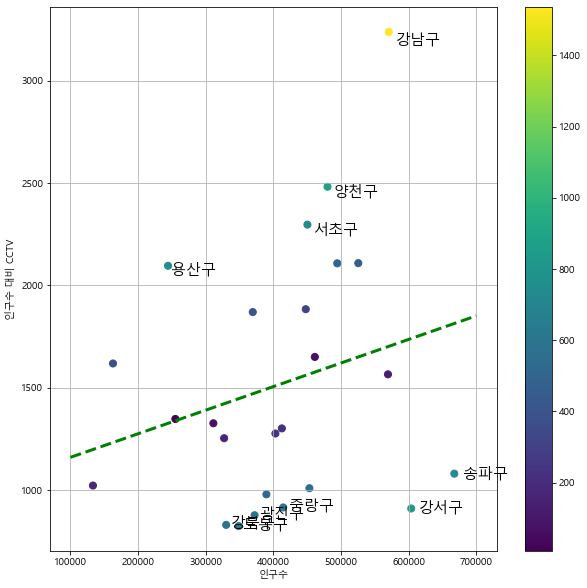

In [150]:
# 오차를 반영한 그래프 작성
# 오차가 큰 10개 구 이름을 그래프에 표시
# 오차 수치로 색상 표현

# 분산형(산점도) 그래프
plt.figure(figsize=(10,10))
plt.scatter(data_result['인구수'],data_result['소계'], 
            c=data_result['오차'], s=50)

plt.plot(x_nums,func(x_nums), ls='dashed',lw=3, color='g')

# 오차가 큰 10개 구만 텍스트 출력
# text(x위치, y위치, 출력 텍스트, 글자크기)
# x * 1.02 : 점보다 약간 오른쪽
# y * 0.98 : 약간 아래
# df_sort.index[n] : 오차가 큰 10개 구 선택
for n in range(10) :
    plt.text(df_sort['인구수'][n]*1.02,
            df_sort['소계'][n]*0.98,
            df_sort.index[n], fontsize=15)
    
plt.xlabel('인구수')
plt.ylabel('인구수 대비 CCTV')

plt.colorbar()
plt.grid()
plt.show()

서울시에서 다른 구와 비교했을 때
- 강남구, 양천구, 서초구, 은평구는 CCTV가 많지만
- 송파구, 강서구, 도봉구, 마포구는 다른 구에 비해 CCTV 비율이 낮다

## 5. 결과를 파일로 저장

In [153]:
# 결과를 '구별'로 정렬한 후 csv 파일로 저장
CCTV_result = data_result.sort_values(by='구별')
CCTV_result.to_csv('../data/01. CCTV_result_euc_kr.csv',
                  header=True,
                  index=True,
                  encoding='euc-kr')

# encoding='euc-kr'로 하면 읽을 때도'euc-kr'로 해야 함

In [154]:
# encoding='utf-8로' 저장
CCTV_result = data_result.sort_values(by='구별')
CCTV_result.to_csv('../data/01. CCTV_result_utf-8.csv',
                  header=True,
                  index=True,
                  encoding='utf-8') # 한글 깨짐

In [156]:
# 저장한 파일 읽어 와서 확인
cctv_result = pd.read_csv('../data/01. CCTV_result_euc_kr.csv',
                         encoding='euc-kr',
                         index_col=0) # 정수 인덱스가 자동으로 붙지 않도록 '구별'을 인덱스로 사용
cctv_result

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율,CCTV비율,오차
구별,,,,,,,,,,
강남구,3238,150.619195,570500.0,565550.0,4950.0,63167.0,0.867660,11.072217,0.567572,1535.448801
강동구,1010,166.490765,453233.0,449019.0,4214.0,54622.0,0.929765,12.051638,0.222843,557.516742
강북구,831,125.203252,330192.0,326686.0,3506.0,54813.0,1.061806,16.600342,0.251672,594.833449
강서구,911,134.793814,603772.0,597248.0,6524.0,72548.0,1.080540,12.015794,0.150885,829.864334
관악구,2109,149.290780,525515.0,507203.0,18312.0,68082.0,3.484582,12.955291,0.401321,458.249607
광진구,878,53.228621,372164.0,357211.0,14953.0,42214.0,4.017852,11.342849,0.235917,596.164747
구로구,1884,64.973730,447874.0,416487.0,31387.0,56833.0,7.007998,12.689506,0.420654,322.654216
금천구,1348,100.000000,255082.0,236353.0,18729.0,32970.0,7.342345,12.925255,0.528458,8.656680
노원구,1566,188.929889,569384.0,565565.0,3819.0,71941.0,0.670725,12.634883,0.275034,135.266110
